In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import pandas as pd
import os
import sklearn

In [2]:
#Get list of filenames in folder
f = 'Beatles/tracks'
songs = [f + '/' + x for x in os.listdir(f)]

In [3]:
#create dataframe
df = pd.DataFrame(songs, columns = ['Song Title'])

In [4]:
#list which loads time series and sampling rate for each song
librosa_data = []
for song in songs:
    librosa_data.append(librosa.load(song))

In [6]:
#load into dataframe
df['y'] = [x[0] for x in librosa_data]
df['sr'] = [x[1] for x in librosa_data]

In [7]:
#load zcr and spectral features using librosa into dataframe
df['Mean ZCR'] = [np.mean(librosa.feature.zero_crossing_rate(x + 0.0001)) for x in df['y']]
df['Spectral Centroid'] = [np.mean(librosa.feature.spectral_centroid(y=x, sr=22050)) for x in df['y']]
df['Spectral Bandwidth'] = [np.mean(librosa.feature.spectral_bandwidth(y=x, sr=22050)) for x in df['y']]
df['Spectral Rolloff'] = [np.mean(librosa.feature.spectral_rolloff(y=x, sr=22050)) for x in df['y']]

In [31]:
#load chroma features into dataframe
chroma1 = []
chroma2 = []
chroma3 = []
chroma4 = []
chroma5 = []
chroma_stft = [librosa.feature.chroma_stft(y=x, sr=22050, n_chroma=5) for x in df['y']]
for i in range(len(chroma_stft)):
    chroma1.append(np.mean(chroma_stft[i][0]))
    chroma2.append(np.mean(chroma_stft[i][1]))
    chroma3.append(np.mean(chroma_stft[i][2]))
    chroma4.append(np.mean(chroma_stft[i][3]))
    chroma5.append(np.mean(chroma_stft[i][4]))
df['Chroma1'] = chroma1
df['Chroma2'] = chroma2
df['Chroma3'] = chroma3
df['Chroma4'] = chroma4
df['Chroma5'] = chroma5

In [32]:
#Load mfcc features into dataframe
mfcc1 = []
mfcc2 = []
mfcc3 = []
mfcc4 = []
mfcc5 = []
mfccs = [librosa.feature.mfcc(y=x, sr=22050, n_mfcc=5) for x in df['y']]
for i in range(len(chroma_stft)):
    mfcc1.append(np.mean(mfccs[i][0]))
    mfcc2.append(np.mean(mfccs[i][1]))
    mfcc3.append(np.mean(mfccs[i][2]))
    mfcc4.append(np.mean(mfccs[i][3]))
    mfcc5.append(np.mean(mfccs[i][4]))
df['MFCC1'] = mfcc1
df['MFCC2'] = mfcc2
df['MFCC3'] = mfcc3
df['MFCC4'] = mfcc4
df['MFCC5'] = mfcc5

In [44]:
#scale features and make new dataframe
sclaer = sklearn.preprocessing.StandardScaler()
scaled_stats = sclaer.fit_transform(df.drop(['Song Title', 'y', 'sr'], axis=1))
scaled = pd.DataFrame(scaled_stats, columns = df.columns[3:])
scaled = pd.concat([df[df.columns[:3]], scaled], axis = 1)

In [154]:
#get dat afrom wikipedia
wiki = pd.read_csv('data/metadata/beatles_wiki_data.csv')

In [155]:
#drop troublesome columns
df2 = df.drop([59, 166, 172]).reset_index()
df2 = df2[df2.columns[2:]]

In [156]:
#get cleaned data from wikipedia and merge with saled feature table
wiki2 = pd.read_csv('beatles_wiki_data_cleaned.csv')
merged = pd.concat([df2, wiki2], axis = 1)

In [158]:
#categorize songwriters into either Lennon and McCartney or other
merged['Songwriters_binary'] = merged['Songwriter(s)'].apply(lambda x: 'lm' if x=='LennonMcCartney' else 'other')
groups = merged.groupby('Songwriters_binary')

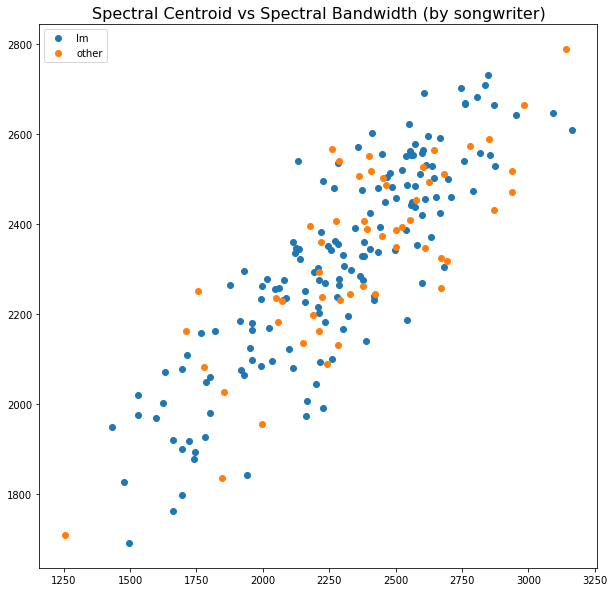

In [160]:
# create a plot with spectral centroid and spectral bandwidth colored by songwriter
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plot
for name, group in groups:
    ax.plot(group['Spectral Centroid'], group['Spectral Bandwidth'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Spectral Centroid vs Spectral Bandwidth (by songwriter)', fontsize=16);
plt.show()

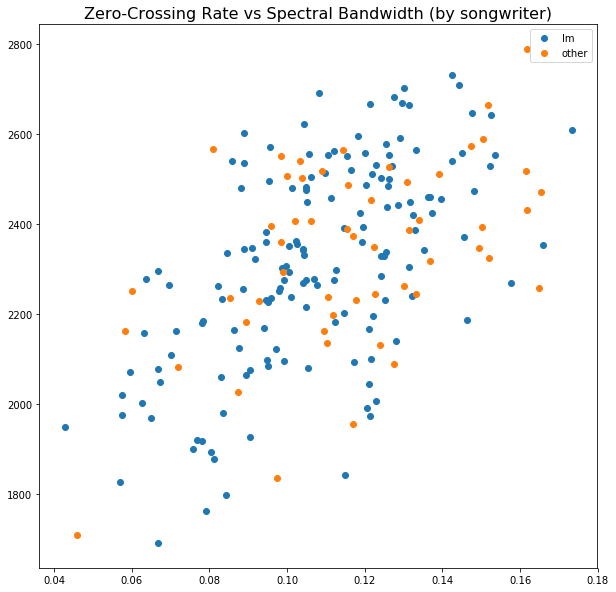

In [162]:
# create a plot with zero crossing rate and spectral bandwidth colored by songwriter
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plot
for name, group in groups:
    ax.plot(group['Mean ZCR'], group['Spectral Bandwidth'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Bandwidth (by songwriter)', fontsize=16);
plt.show()

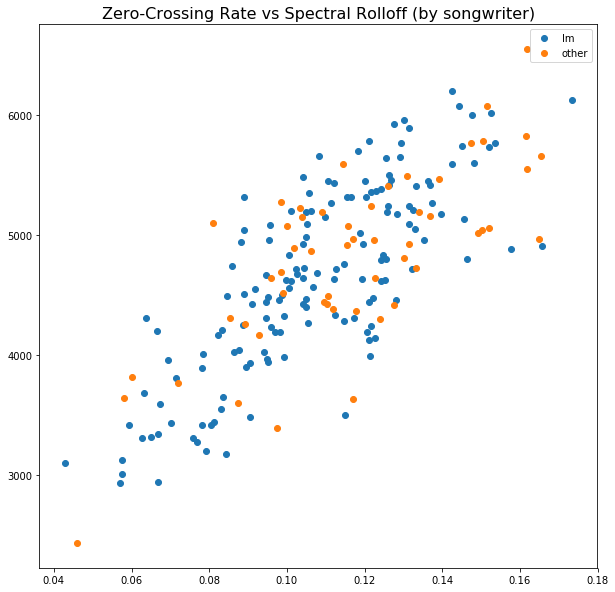

In [163]:
# create a plot with zero crossing rate and spectral rolloff colored by songwriter
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plot
for name, group in groups:
    ax.plot(group['Mean ZCR'], group['Spectral Rolloff'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Rolloff (by songwriter)', fontsize=16);
plt.show()

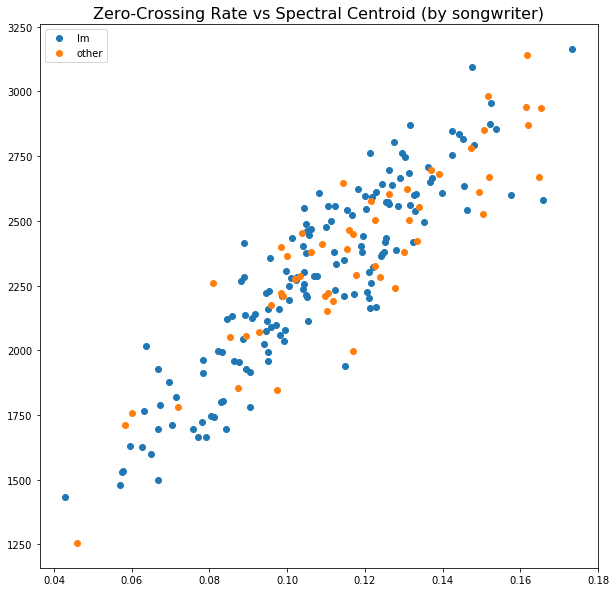

In [187]:
# create a plot with zero crossing rate and spectral rolloff colored by songwriter
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plot
for name, group in groups:
    ax.plot(group['Mean ZCR'], group['Spectral Centroid'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Centroid (by songwriter)', fontsize=16);
plt.show()

In [176]:
#function that groups multiple lead vocals into mixed and fixes some mislabeled entries
def group_vocals(x):
    if x in ['LennonMcCartney', 'Lennon(with McCartney)', 'McCartney(with Lennon)',
             'Lennon(with McCartneyand Harrison)', 'McCartneyLennonHarrison',
             'LennonMcCartneyHarrison', 'LennonHarrison']:
        return 'Mixed'
    elif x in ['John Lennon', 'Lennon(with Yoko Ono)']:
        return 'Lennon'
    elif x == 'Paul McCartney':
        return 'McCartney'
    elif x == 'Ringo Starr':
        return 'Starr'
    elif x in ['Instrumental', 'Sound Collage']:
        return 'Other'
    else:
        return x

In [180]:
# runs function and groups by cleaned column
merged['Lead vocals grouped'] = merged['Lead vocal(s)[d]'].apply(group_vocals)
vocal_groups = merged.groupby('Lead vocals grouped')

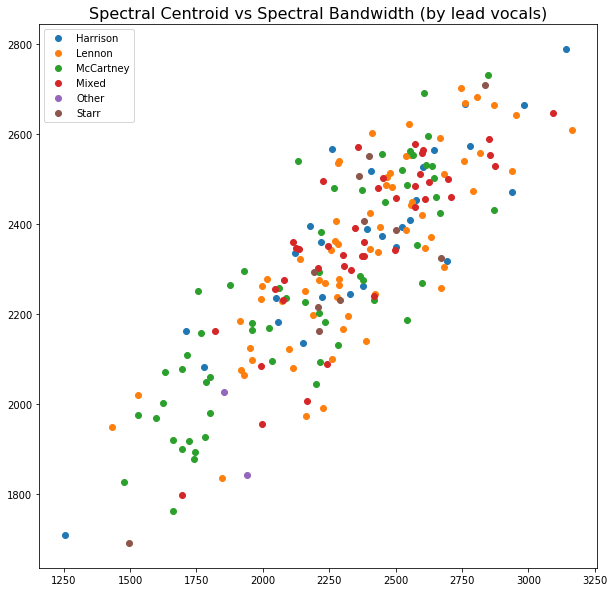

In [181]:
# create a plot with spectral centroid and spectral bandwidth colored by lead vocals
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plots
for name, group in vocal_groups:
    ax.plot(group['Spectral Centroid'], group['Spectral Bandwidth'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Spectral Centroid vs Spectral Bandwidth (by lead vocals)', fontsize=16);
plt.show()

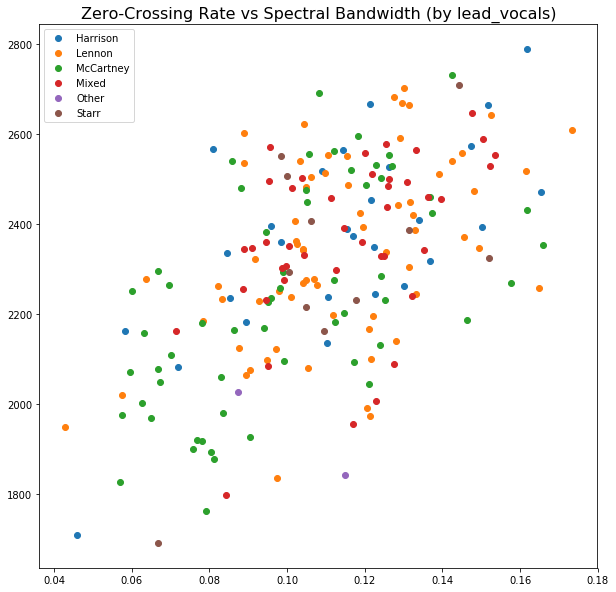

In [183]:
# create a plot with zero crossing rate and spectral bandwidth colored by lead vocals
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plots
for name, group in vocal_groups:
    ax.plot(group['Mean ZCR'], group['Spectral Bandwidth'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Bandwidth (by lead_vocals)', fontsize=16);
plt.show()

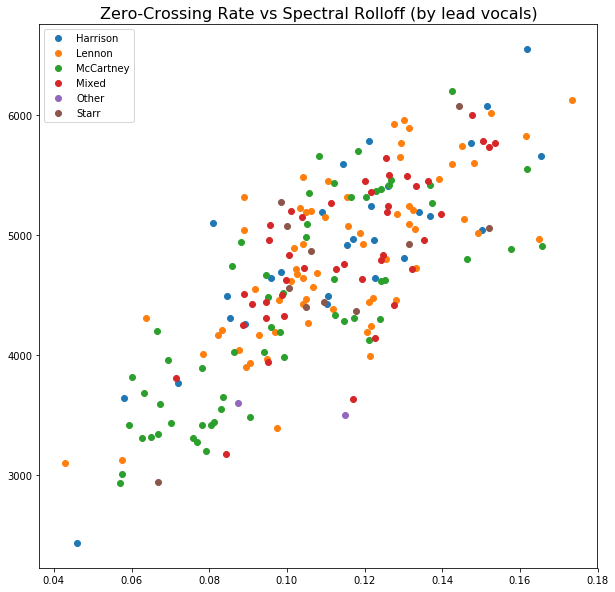

In [184]:
# create a plot with zero crossing rate and spectral rolloff colored by lead vocals
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plots
for name, group in vocal_groups:
    ax.plot(group['Mean ZCR'], group['Spectral Rolloff'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Rolloff (by lead vocals)', fontsize=16);
plt.show()

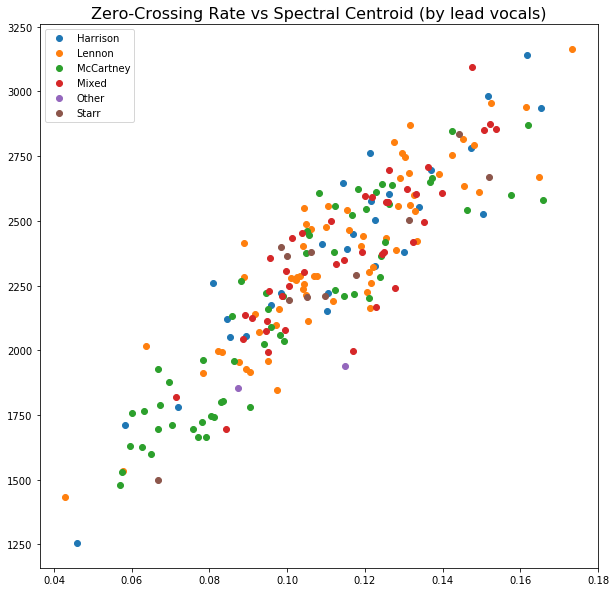

In [186]:
# create a plot with zero crossing rate and spectral centroid colored by lead vocals
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05)

# loop over groups and add to plots
for name, group in vocal_groups:
    ax.plot(group['Mean ZCR'], group['Spectral Centroid'], marker='o', linestyle='', label=name)
ax.legend()
plt.title('Zero-Crossing Rate vs Spectral Centroid (by lead vocals)', fontsize=16);
plt.show()